In [288]:
import os
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import NullFormatter
from osgeo import gdal
from PIL import Image
from sklearn import metrics
#from sklearn.ensemble import RandomForestClassifer
from skimage import io

References:<br />
http://gisgeography.com/image-classification-techniques-remote-sensing/


# Lab 6: Image Classification

SIO 236<br />
Moon Limb

Background (Copied directly from the lab):

This section uses a composite image of Wilkins Sound in the Antarctic Peninsula made from the first seven spectral bands of data collected by MODIS (which stands for Moderate Resolution Imaging Spectrora- diometer). ...

This particular image was chosen because it depicts an episode of the disintegration of the Wilkins Ice Shelf in March 2008. A team led by researchers at the National Snow and Ice Data Center and the Scripps Institution of Oceanography wrote a journal article [1] detailing how this event was observed through remote sensing, which may be accessed at http://dx.doi.org/10.1016/j.epsl.2008.12.027.

Update

|band #|min (μm) |center (μm)| color    | applications |
|------|---------|-----------|----------|-----------------------|
|  1   |  0.620  |  0.670    |  Red     |Absolute land cover transformation, Vegetation 
|  2   |  0.841  |  0.876    |  Near-IR |Cloud amount, Vegetation land cover transformation
|  3   |  0.459  |  0.479    |  Blue    |Soil/vegetation differences
|  4   |  0.545  |  0.565    |  Green   |Green vegetation
|  5   |  1.230  |  1.250    |  Mid-IR  |Leaf/canopy differences 
|  6   |  1.628  |  1.652    |  Mid-IR  |Snow/cloud differences 
|  7   |  2.105  |  2.155    |  Mid-IR  |Cloud properties, Land properties 
#### <center>Table 2.1: MODIS Spectral Bands

## Image of Wilkins Sound MODIS (Scambos et al. 2009)

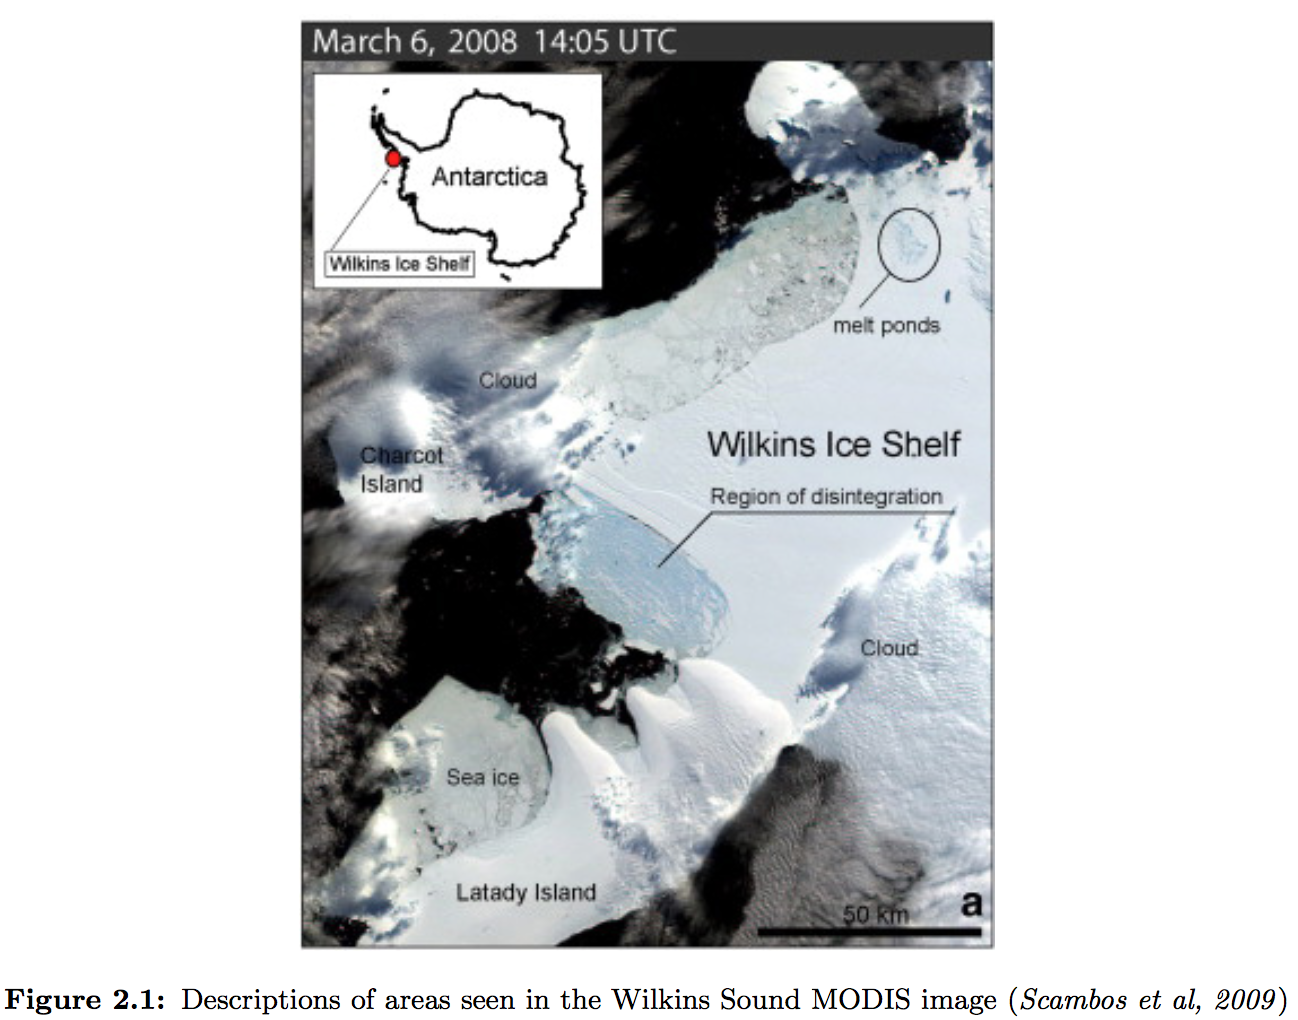

In [289]:
# namespacing for now b/c PIL library also has Image
def show_image():
    from IPython.display import Image
    return Image(filename='./fig_wilkins_sound.png') 

show_image()

# 2.1 Exercise 1

1. Read all 7 bands of the Wilkins Sound MODIS image **<span style="color:black; background-color: yellow">DONE</span>**.
2. Display all 7 bands individually **<span style="color:black; background-color: yellow">DONE</span>**.
3. Display an RGB image **<span style="color:black; background-color: yellow">DONE</span>**.

NOTE: RGB image will be used to identify pixels for the training set

In [290]:
"""
Read .dat files (dtype is unsigned integer)
"""
# in some cases, it's bad to mix data + displayable content
# but this approach avoids manually supplying plot title
# and all band-relevant information is in one place

# Make ordered dict to preserve order of band #s
bands = OrderedDict()

# list of dictionaries. each band has a dictionary with 
# displayable name (title) and file name/location (source)
bands['red'] = {'title': 'Red', 'source': './modis.dat/modis1.dat'}
bands['nif'] = {'title': 'Near-Infrared', 'source': './modis.dat/modis2.dat'}
bands['blue'] = {'title': 'Blue', 'source': './modis.dat/modis3.dat'}
bands['green'] = {'title': 'Green', 'source': './modis.dat/modis4.dat'}
bands['mif1'] = {'title': 'Mid-Infrared1', 'source': './modis.dat/modis5.dat'}
bands['mif2'] = {'title': 'Cloud (Mid-Infrared2)', 'source': './modis.dat/modis6.dat'}
bands['mif3'] = {'title': 'Mid-Infrared3', 'source': './modis.dat/modis7.dat'}

# alternatively, 
#files = [f for f in os.listdir("./modis.dat/") if f.endswith('.dat')]
# ...

# np.fromfile requires reshaping by specifying the dimensions
# np.loadtxt doesn't and loads 400 by 400 2D-array

# I am modifying the object I am looping over. 
# this is a bad approach when dealing with larger data
for _, band in bands.iteritems():
    band['data'] = np.loadtxt(band['source'], dtype='uint8')

### Make a composite RGB image

In [291]:
red = bands['red']['data']
green = bands['green']['data']
blue = bands['blue']['data']

rgb_image = Image.fromarray(np.stack([red, green, blue], axis=2), mode='RGB')

#### Function to display a grayscale image

In [292]:
# reusing function from Lab5
def plot_band_graysc(_plt, _subplot_num, _data, _title):
    """ Plot the given band (data) in grayscale
    
    data (numpy array)
    title (string): plot title
    """
    _plt.subplot(_subplot_num)
    _plt.imshow(_data, cmap=plt.cm.gray)

    # label axes
#    _plt.xlabel('X')
#    _plt.ylabel('Y')
    _plt.title(_title, fontsize=16) 
    

### Display all 7 bands individually AND display a composite RGB image

In [293]:
plt.close()
plt.figure(figsize=(16, 8))

In [294]:
# list of subplot numbers
ls_subplots = xrange(241, 248+1)

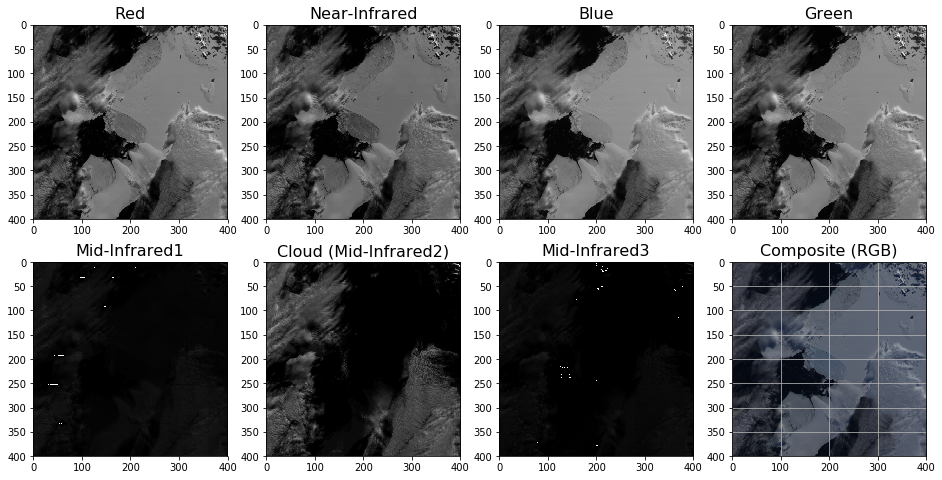

In [295]:
# unpacks bands
# i -> index #, should range from [0, len(bands)-1], which is [0, 7]
#       will be used to access axes
# _ -> band key names (ex.'red', 'nif'); unnamed b/c that will not be used here
# band -> dictionary defined above, containg these keys: 'source', 'data', 'title'

for i, [_, band] in enumerate(bands.iteritems()):
    plot_band_graysc(plt, ls_subplots[i], band['data'], band['title'])

# Add RGB image
plot_band_graysc(plt, ls_subplots[-1], rgb_image, 'Composite (RGB)')
plt.grid()
plt.show() 

## Make a gridded image to pick out 2 pixels per group

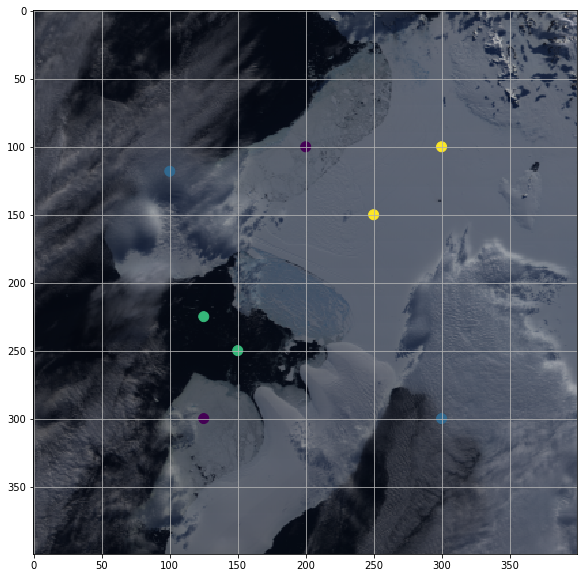

In [296]:
plt.close()
plt.figure(figsize=(10, 10))

# Add RGB image
plt.imshow(rgb_image, cmap=plt.cm.gray)
plt.grid()

# Validation: plot training pixel points on the plot to confirm
# x and y pixel coordinates are grouped correctly
plt.scatter(xs, ys, c=tpix[:,2], s=100)
plt.show()

# 2.2 Exercise 2

Prep data:

1. Decide: How many groups/classes to sort image into (ex. sea ice, open ocean, clouds, etc.) **<span style="color:black; background-color: yellow">DONE</span>**.
2. Identify: at least 2 training pixels per group **<span style="color:black; background-color: yellow">DONE</span>**.
3. Create a 3-column matrix (`tpix`) containing the a) row, b) column, and c) group number of each training pixel **<span style="color:black; background-color: yellow">DONE</span>**.
4. Create a 7-col matrix (`train`) continaing each of the 7 band-values for every pixel identified in `tpix` **<span style="color:black; background-color: yellow">DONE</span>**.

Tip: Each line of `tpix` should have 3 numbers in the following format:
    (row, col, group)

#### Run classify command:

MATLAB command: 
```MATLAB
[class, err, misfit] = classify(AllPix, train, group)
```
where

    `Allpix` is matrix of 7 band values for each pixel across the image
    `train` is the trainng set
    `group`  is the group each training pixel belongs too
    `class` is a vector telling which group each pixel belongs to
    `err` is dummy varaible that can be ignored
    `misfit` is a matrix telling how well each pixel fits into each group, 0=doesn't fit 1= perfect fit
    

#### Four groups are:

1. Sea Ice

2. Ocean

3. Clouds

4. Snow

#### Unsupervised Learning Using Kmeans

In [297]:
groups = {'sea_ice': 0, 'ocean': 1, 'cloud': 2, 'snow': 3}
group_colors = np.uint8([[0, 255, 0], [255, 0, 0], [0, 0, 255], [50, 50, 50]])

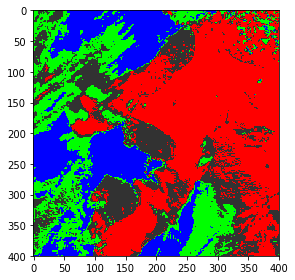

In [298]:
from sklearn.cluster import KMeans
from skimage import io

def classify_kmeans_unsupervised(_img_name, _groups, _group_colors):
    img = io.imread(_img_name)
    n_groups = len(_groups)

    rows, cols, bands = img.shape
    X = img.reshape(rows*cols, bands)
    
    kmeans = KMeans(n_clusters=n_groups, random_state=0).fit(X)
    unsupervised = kmeans.labels_.reshape(rows, cols)
    io.imshow(_group_colors[unsupervised])
    io.show()
    
#     print rows, cols, bands
rgb_image.save("rgb_image.jpg")
classify_kmeans_unsupervised("rgb_image.jpg", groups, group_colors)

ANS> Unsupervised learnning based on kmeans cluster with 4 groups seem to identify snow (red), clouds (green), ocean (blue), and sea ice (dark gray). As expected, without the incorporation of mid-infrared bands such s the one for cloud mid-infrared2, the algorithm has a hard time telling apart a cloud-covered surface as a cloud, but instead categorizes some cloud to a combination of snow and sea ice.

Supervised learning from the same source. 

In [299]:
# supervised = n_groups*np.ones(shape=(rows, cols), dtype=np.int)
# supervised[250:300, 100:160] = groups['snow']
# supervised[40:60, 40:60] = classes['vegetation']
# supervised[100:120, 200:220] = classes['water']

### Identify: at least 2 training pixels per group
### Make `tpix` -- 3 colum matrix in row, col, group # format

In [300]:
# (x, y, group_num)

# Format: `row col group_num; row col group_num; ...' 
# create matrix of 3 columns and 8 rows (2 per each group)
tpix = np.array(
    np.matrix('125 300 0; 200 100 0; 300 300 1; 100 118 1;'+
        '150 250 2; 125 225 2; 250 150 3; 300 100 3'))
# 0 sea ice
# 1 cloud
# 2 ocean
# 3 snow

In [301]:
tpix

array([[125, 300,   0],
       [200, 100,   0],
       [300, 300,   1],
       [100, 118,   1],
       [150, 250,   2],
       [125, 225,   2],
       [250, 150,   3],
       [300, 100,   3]])

In [302]:
xs = tpix[:,0]
ys = tpix[:,1]

### Make `train` --  A 7-col matrix continaing each of the 7 band-values for every pixel in `tpix`


In [303]:
# just checking
# bands['red']['data']

In [304]:
# manual check
for pix in tpix:
    print pix

[125 300   0]
[200 100   0]
[300 300   1]
[100 118   1]
[150 250   2]
[125 225   2]
[250 150   3]
[300 100   3]


In [305]:
# just checking the order of bands
bands.keys()

['red', 'nif', 'blue', 'green', 'mif1', 'mif2', 'mif3']

In [306]:
# 8 rows -> per pixel
# 7 columns -> per  band

train = np.empty([8, 7], dtype="uint8")

for i, pix in enumerate(tpix):
    x = pix[0]
    y = pix[1]
    train[i, 0] = bands['red']['data'][x, y]
    train[i, 1] = bands['nif']['data'][x, y]
    train[i, 2] = bands['blue']['data'][x, y]
    train[i, 3] = bands['green']['data'][x, y]
    train[i, 4] = bands['mif1']['data'][x, y]
    train[i, 5] = bands['mif2']['data'][x, y]
    train[i, 6] = bands['mif3']['data'][x, y]

In [307]:
# train

In [308]:
# tlabels =[
#     'sea_ice', 'sea_ice',
#     'cloud', 'cloud',
#     'ocean', 'ocean',
#     'snow',  'snow']

tlabels = [0,0,1,1,2,2,3,3]

# 0 sea ice
# 1 cloud
# 2 ocean
# 3 snow

In [309]:
tpix

array([[125, 300,   0],
       [200, 100,   0],
       [300, 300,   1],
       [100, 118,   1],
       [150, 250,   2],
       [125, 225,   2],
       [250, 150,   3],
       [300, 100,   3]])

In [310]:
tlabels
tlabels = [0,0,1,1,2,2,3,3]

In [311]:
# A list of "random" colors (for a nicer output)
# COLORS = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF"] #, "#FF4A46", "#008941"]
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(train, tlabels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

bands_data = []

for k, v in bands.iteritems():
    bands_data.append(v['data'])

# print bands_data
# param: sequence of arrays of same shape (except 3rd axis) to stack 
# returns: stacked array
bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape
print rows
print n_bands # -> 7

In [312]:
bands_data = []

for k, v in bands.iteritems():
    bands_data.append(v['data'])

# print bands_data
# param: sequence of arrays of same shape (except 3rd axis) to stack 
# returns: stacked array
bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape
# results in rows = 400, cols = 400, and n_bands = 7

In [313]:
n_samples = rows*cols #16000

In [314]:
flat_pixels = bands_data.reshape((n_samples, n_bands))
#flat_pixels.shape -> (160000, 7)

# Run Classification (Random Forrest)

In [315]:
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

In [316]:
# I manually checked the classification values for training pixels were correct

In [317]:
# check the order to provide correct rgb value for creating rgb image
# alternatively, can just uses rgb image created above
bands.keys()

['red', 'nif', 'blue', 'green', 'mif1', 'mif2', 'mif3']

In [318]:
classification

array([[0, 0, 1, ..., 1, 1, 1],
       [0, 3, 3, ..., 1, 1, 1],
       [1, 3, 3, ..., 1, 1, 1],
       ..., 
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 3],
       [0, 0, 3, ..., 3, 3, 1]])

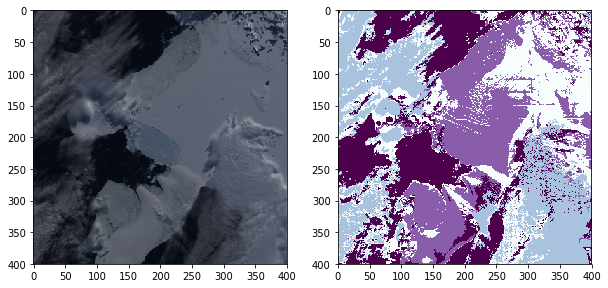

In [319]:
f = plt.figure(figsize=(10,10))

# Plot RGB image
f.add_subplot(1, 2, 1)
r = bands_data[:,:,0]
b = bands_data[:,:,2]
g = bands_data[:,:,3]
rgb = np.dstack([r,g,b])
plt.imshow(rgb)

# Plot classified image. Maps labels [0, 3] to colormap Blue Purple
f.add_subplot(1, 2, 2)
plt.imshow(classification, cmap=plt.cm.BuPu)
plt.show()

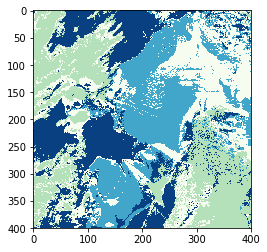

In [320]:
# Alternative coloring
f.add_subplot(1, 2, 2)
plt.imshow(classification, cmap=plt.cm.GnBu)
plt.show()

## Exercise 2.3

Reshape class and misfit back into matrices `nx x ny`
Look at the classiication with equivalent of MATLAB's `image` or `imagesc` (can use colormap)

Questions:

1. Does the classification make sense? YES!

2. Is all the ocean in one group? YES!

3. All the clouds in another? Not exactly. Part of the clouds got categoraized as 
snow, especially the boundaries. But pretty good job.

In [321]:
print Image.fromarray.__doc__


    Creates an image memory from an object exporting the array interface
    (using the buffer protocol).

    If obj is not contiguous, then the tobytes method is called
    and :py:func:`~PIL.Image.frombuffer` is used.

    :param obj: Object with array interface
    :param mode: Mode to use (will be determined from type if None)
      See: :ref:`concept-modes`.
    :returns: An image object.

    .. versionadded:: 1.1.6
    


**Used Reources:**

1. Unsupervised learning using kmeans https://stackoverflow.com/questions/43331510/how-to-train-an-svm-classifier-on-a-satellite-image-using-python/43386604

2. Supervised learning using Random Forest https://www.machinalis.com/blog/python-for-geospatial-data-processing/

**Few others references** (not directly used/helpful):

3. 10 algorithms Machine Learning Engineers Need to Know http://www.kdnuggets.com/2016/08/10-algorithms-machine-learning-engineers.html/2 - just to get little bit more background

4. Image Classification with Python http://remote-sensing.eu/image-classification-with-python/
5. http://geoinformaticstutorial.blogspot.com/2016/02/k-means-clustering-of-satellite-images.html (NOT used)

6. http://blog.yhat.com/posts/image-classification-in-Python.html (NOT used)

7. https://github.com/kscottz/PythonFromSpace (Watched the talk on YouTube- not directly helpful)